In [1]:
import os
import cv2
import numpy as np
import tritonclient.grpc as grpcclient
from tritonclient.utils import InferenceServerException

In [2]:
import cv2
import matplotlib.pyplot as plt

BOX_COLOR = (255, 0, 0)  # Red
TEXT_COLOR = (255, 255, 255)  # White
LEFT_COLOR = (255, 0, 0)
CENTER_COLOR = (0, 255, 0)
RIGHT_COLOR = (0, 0, 255)


def clip(x, y, width, height, normalized=False):
    if normalized:
        x = x * width
        y = y * height
    x = max(x, 0)
    y = max(y, 0)
    x = min(x, width)
    y = min(y, height)
    x = int(round(x))
    y = int(round(y))
    return x, y


def visualize_bbox(
    img,
    bbox,
    landmark,
    landmark_mask,
    color=BOX_COLOR,
    thickness=2,
    radius=2,
    bbox_type="coco",
    landmark_normalized: bool = True,
):
    r"""Visualizes a single bounding box on the image
    Args:
        bbox: coco
    """

    if bbox_type == "coco":
        x_min, y_min, w, h = bbox
        x_min, x_max, y_min, y_max = (
            int(x_min),
            int(x_min + w),
            int(y_min),
            int(y_min + h),
        )
    elif bbox_type == "pascal_voc":
        x_min, y_min, x_max, y_max = bbox
    elif bbox_type == "albumentations":
        x_min, y_min, x_max, y_max = bbox
        x_min, y_min, x_max, y_max = (
            int(x_min * img.shape[1]),
            int(y_min * img.shape[0]),
            int(x_max * img.shape[1]),
            int(y_max * img.shape[0]),
        )
    elif bbox_type == "yolo":
        cx, cy, w, h = bbox
        x_min, y_min, x_max, y_max = cx - w / 2, cy - h / 2, cx + w / 2, cy + h / 2
        x_min, y_min, x_max, y_max = (
            int(x_min * img.shape[1]),
            int(y_min * img.shape[0]),
            int(x_max * img.shape[1]),
            int(y_max * img.shape[0]),
        )
    else:
        raise KeyError("bbox_type error")

    x_min, y_min, x_max, y_max = (
        int(round(x_min)),
        int(round(y_min)),
        int(round(x_max)),
        int(round(y_max)),
    )

    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)

    if landmark is not None and landmark_mask is not None:
        if landmark_mask[0] > 0:
            img = cv2.circle(
                img,
                clip(
                    landmark[0],
                    landmark[1],
                    img.shape[1],
                    img.shape[0],
                    landmark_normalized,
                ),
                radius=radius,
                color=LEFT_COLOR,
                thickness=-1,
            )
        if landmark_mask[1] > 0:
            img = cv2.circle(
                img,
                clip(
                    landmark[2],
                    landmark[3],
                    img.shape[1],
                    img.shape[0],
                    landmark_normalized,
                ),
                radius=radius,
                color=RIGHT_COLOR,
                thickness=-1,
            )
        if landmark_mask[2] > 0:
            img = cv2.circle(
                img,
                clip(
                    landmark[4],
                    landmark[5],
                    img.shape[1],
                    img.shape[0],
                    landmark_normalized,
                ),
                radius=radius,
                color=CENTER_COLOR,
                thickness=-1,
            )
        if landmark_mask[3] > 0:
            img = cv2.circle(
                img,
                clip(
                    landmark[6],
                    landmark[7],
                    img.shape[1],
                    img.shape[0],
                    landmark_normalized,
                ),
                radius=radius,
                color=LEFT_COLOR,
                thickness=-1,
            )
        if landmark_mask[4] > 0:
            img = cv2.circle(
                img,
                clip(
                    landmark[8],
                    landmark[9],
                    img.shape[1],
                    img.shape[0],
                    landmark_normalized,
                ),
                radius=radius,
                color=RIGHT_COLOR,
                thickness=-1,
            )

    return img


def visualize(
    image,
    bboxes,
    landmarks,
    landmarks_mask,
    bbox_type="coco",
    thickness=2,
    radius=2,
    landmark_normalized: bool = True,
):
    img = image.copy()
    for bbox, landmark, landmark_mask in zip(bboxes, landmarks, landmarks_mask):
        img = visualize_bbox(
            img,
            bbox,
            landmark,
            landmark_mask,
            bbox_type=bbox_type,
            thickness=thickness,
            radius=radius,
            landmark_normalized=landmark_normalized,
        )
    plt.figure(figsize=(10, 10))
    plt.axis("off")
    plt.imshow(img)
    plt.show()


In [3]:
# Create server context
try:
    triton_client = grpcclient.InferenceServerClient(
        url="10.1.1.41:48001",
        verbose=False,
        ssl=False,
        root_certificates=None,
        private_key=None,
        certificate_chain=None,
    )
except Exception as e:
    print("context creation failed: " + str(e))
    sys.exit()

    # Health check
    if not triton_client.is_server_live():
        print("FAILED : is_server_live")
        sys.exit(1)

    if not triton_client.is_server_ready():
        print("FAILED : is_server_ready")
        sys.exit(1)

    if not triton_client.is_model_ready(FLAGS.model):
        print("FAILED : is_model_ready")
        sys.exit(1)


In [4]:
image_data = cv2.cvtColor(
    cv2.imread(os.path.join(os.path.dirname("__file__"), "sample.jpg")),
    cv2.COLOR_BGR2RGB,
)
image_data = np.expand_dims(image_data, axis=0)
print(image_data.shape)

(1, 768, 1024, 3)


## Face detection


In [5]:
INPUT_NAMES = ["IMAGE"]
OUTPUT_NAMES = ["num_dets", "det_boxes", "det_scores", "det_classes", "det_lmks"]


inputs = []
outputs = []
inputs.append(grpcclient.InferInput(INPUT_NAMES[0], image_data.shape, "UINT8"))
outputs.append(grpcclient.InferRequestedOutput(OUTPUT_NAMES[0]))
outputs.append(grpcclient.InferRequestedOutput(OUTPUT_NAMES[1]))
outputs.append(grpcclient.InferRequestedOutput(OUTPUT_NAMES[2]))
outputs.append(grpcclient.InferRequestedOutput(OUTPUT_NAMES[3]))
outputs.append(grpcclient.InferRequestedOutput(OUTPUT_NAMES[4]))

inputs[0].set_data_from_numpy(image_data)

In [6]:
%%time
results = triton_client.infer(model_name="FaceDetectionAssemble", inputs=inputs, outputs=outputs)

num_dets = results.as_numpy(OUTPUT_NAMES[0])[0]
det_boxes = results.as_numpy(OUTPUT_NAMES[1])[0]
det_scores = results.as_numpy(OUTPUT_NAMES[2])[0]
det_classes = results.as_numpy(OUTPUT_NAMES[3])[0]
det_lmks = results.as_numpy(OUTPUT_NAMES[4])[0]

CPU times: user 0 ns, sys: 8.99 ms, total: 8.99 ms
Wall time: 5.32 s


In [7]:
print(num_dets.shape)
print(det_boxes.shape)
print(det_scores.shape)
print(det_classes.shape)
print(det_lmks.shape)

(1,)
(100, 4)
(100,)
(100,)
(100, 10)


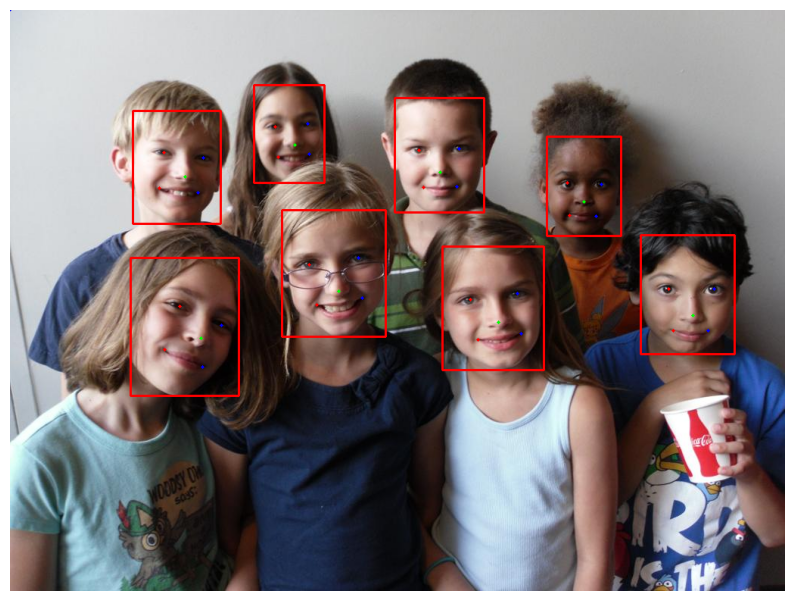

In [8]:
visualize(
    image_data[0].copy(),
    det_boxes,
    det_lmks,
    np.ones((det_boxes.shape[0], 5)),
    bbox_type="pascal_voc",
    landmark_normalized=False,
)

## Face aligment

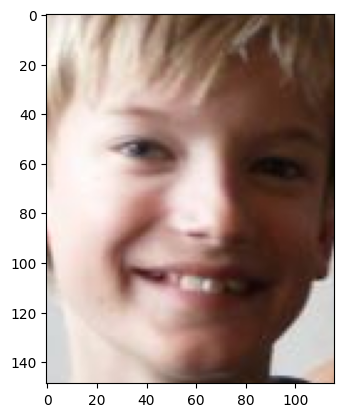

In [9]:
def crop(image, box, lmks):
    x1, y1, x2, y2 = box
    x1, y1, x2, y2 = int(round(x1)), int(round(y1)), int(round(x2)), int(round(y2))
    new_image = image[y1:y2, x1:x2, :].copy()
    lmks = lmks.copy()
    lmks[0::2] -= x1
    lmks[1::2] -= y1
    return new_image, lmks


crop_image, crop_lmks = crop(image_data[0], det_boxes[1], det_lmks[1])

plt.imshow(crop_image)
plt.show()

In [10]:
def face_recogition_preprocessing(image, lmks, target_shape):
    origin_shape = image.shape[:2]
    image = cv2.resize(image, target_shape)
    lmks[0::2] *= target_shape[1] / origin_shape[1]
    lmks[1::2] *= target_shape[0] / origin_shape[0]
    return image, lmks

crop_image, crop_lmks = face_recogition_preprocessing(crop_image, crop_lmks, (112, 112))
crop_image, crop_lmks = np.expand_dims(crop_image, axis=0), np.expand_dims(crop_lmks, axis=0)
crop_image.shape, crop_image.dtype, crop_lmks.shape, crop_lmks.dtype

((1, 112, 112, 3), dtype('uint8'), (1, 10), dtype('float32'))

### Using Triton

In [11]:
INPUT_NAMES = ["INPUT0", "INPUT1"]
OUTPUT_NAMES = ["OUTPUT"]


inputs = []
outputs = []
inputs.append(grpcclient.InferInput(INPUT_NAMES[0], crop_image.shape, "UINT8"))
inputs.append(grpcclient.InferInput(INPUT_NAMES[1], crop_lmks.shape, "FP32"))
outputs.append(grpcclient.InferRequestedOutput(OUTPUT_NAMES[0]))

inputs[0].set_data_from_numpy(crop_image)
inputs[1].set_data_from_numpy(crop_lmks)

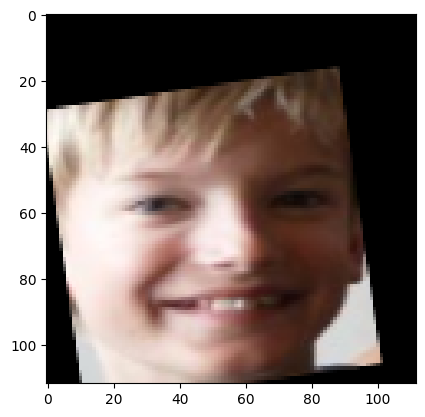

CPU times: user 155 ms, sys: 182 ms, total: 337 ms
Wall time: 134 ms


In [12]:
%%time
results = triton_client.infer(model_name="FaceAligment", inputs=inputs, outputs=outputs)

output = results.as_numpy(OUTPUT_NAMES[0])[0]

plt.imshow(output)
plt.show()

### Using skimage

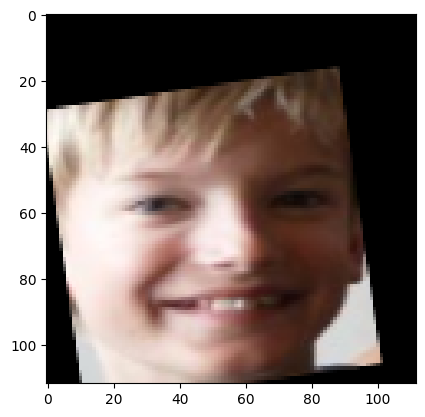

In [13]:
import cv2
import numpy as np
from skimage import transform as trans

output_size = (112, 112)
default_array = np.array(
    [
        [30.29459953 + 8, 51.69630051],
        [65.53179932 + 8, 51.50139999],
        [48.02519989 + 8, 71.73660278],
        [33.54930115 + 8, 92.3655014],
        [62.72990036 + 8, 92.20410156],
    ],
    dtype=np.float32,
)


def align_image(image, landmarks):
    landmarks = np.array(landmarks, dtype=np.float32).reshape(5, 2)

    tform = trans.SimilarityTransform()
    tform.estimate(landmarks, default_array)
    tfm = tform.params[0:2, :]
    return cv2.warpAffine(image, tfm, (output_size[0], output_size[1]))


new_image = align_image(crop_image[0], crop_lmks[0])

plt.imshow(new_image)
plt.show()

## Face recogition

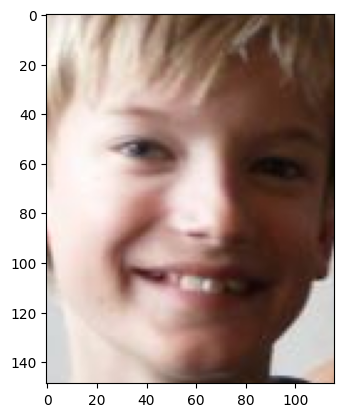

In [14]:
def crop(image, box, lmks):
    x1, y1, x2, y2 = box
    x1, y1, x2, y2 = int(round(x1)), int(round(y1)), int(round(x2)), int(round(y2))
    new_image = image[y1:y2, x1:x2, :].copy()
    lmks = lmks.copy()
    lmks[0::2] -= x1
    lmks[1::2] -= y1
    return new_image, lmks


crop_image, crop_lmks = crop(image_data[0], det_boxes[1], det_lmks[1])

plt.imshow(crop_image)
plt.show()


In [15]:
crop_image, crop_lmks = np.expand_dims(crop_image, axis=0), np.expand_dims(crop_lmks, axis=0)
crop_image.shape, crop_image.dtype, crop_lmks.shape, crop_lmks.dtype

((1, 149, 116, 3), dtype('uint8'), (1, 10), dtype('float32'))

In [16]:
INPUT_NAMES = ["INPUT0", "INPUT1"]
OUTPUT_NAMES = ["OUTPUT"]


inputs = []
outputs = []
inputs.append(grpcclient.InferInput(INPUT_NAMES[0], crop_image.shape, "UINT8"))
inputs.append(grpcclient.InferInput(INPUT_NAMES[1], crop_lmks.shape, "FP32"))
outputs.append(grpcclient.InferRequestedOutput(OUTPUT_NAMES[0]))

inputs[0].set_data_from_numpy(crop_image)
inputs[1].set_data_from_numpy(crop_lmks)

In [17]:
%%time
results = triton_client.infer(model_name="FaceRecognitionAssemble", inputs=inputs, outputs=outputs)

output = results.as_numpy(OUTPUT_NAMES[0])[0]
output

CPU times: user 548 µs, sys: 1.59 ms, total: 2.14 ms
Wall time: 16.6 ms


array([-1.67871094e+00,  3.05175781e-01,  1.20410156e+00, -4.40917969e-01,
        1.17871094e+00,  2.43408203e-01, -8.86230469e-01, -1.49414062e+00,
       -2.52148438e+00,  8.43505859e-02, -6.87866211e-02, -1.03320312e+00,
       -6.65283203e-02, -1.20117188e+00,  1.97998047e-01, -1.03320312e+00,
       -5.71777344e-01, -1.20239258e-01, -3.32031250e-01,  1.49707031e+00,
       -1.19921875e+00, -6.14013672e-02,  8.64257812e-01, -1.06640625e+00,
        1.47167969e+00,  3.41308594e-01, -4.17236328e-01, -1.09375000e+00,
        1.30273438e+00, -3.34960938e-01, -8.90136719e-01,  4.99267578e-01,
        1.13867188e+00,  1.47460938e-01, -4.70947266e-01,  1.45996094e-01,
        1.71679688e+00,  6.48437500e-01, -2.00195312e+00, -2.81445312e+00,
       -4.90966797e-01,  1.13867188e+00,  1.00976562e+00, -7.53906250e-01,
       -1.00000000e+00, -9.38476562e-01,  2.32543945e-02, -7.79785156e-01,
       -1.38061523e-01, -3.20068359e-01, -5.25390625e-01, -1.10900879e-01,
       -1.10351562e+00,  

## End2end

In [18]:
INPUT_NAMES = ["INPUT"]
OUTPUT_NAMES = [
    "num_dets",
    "det_boxes",
    "det_scores",
    "det_classes",
    "det_lmks",
    "has_features",
    "features",
]

inputs = []
outputs = []
inputs.append(grpcclient.InferInput(INPUT_NAMES[0], image_data.shape, "UINT8"))
for output_name in OUTPUT_NAMES:
    outputs.append(grpcclient.InferRequestedOutput(output_name))

inputs[0].set_data_from_numpy(image_data)

In [21]:
%%time
results = triton_client.infer(model_name="FaceAssemble", inputs=inputs, outputs=outputs)

num_dets = results.as_numpy(OUTPUT_NAMES[0])[0]
det_boxes = results.as_numpy(OUTPUT_NAMES[1])[0]
det_scores = results.as_numpy(OUTPUT_NAMES[2])[0]
det_classes = results.as_numpy(OUTPUT_NAMES[3])[0]
det_lmks = results.as_numpy(OUTPUT_NAMES[4])[0]
has_features = results.as_numpy(OUTPUT_NAMES[5])[0]
features = results.as_numpy(OUTPUT_NAMES[6])[0]

CPU times: user 3.39 ms, sys: 2.23 ms, total: 5.62 ms
Wall time: 107 ms


In [22]:
features

array([[ 0.09277344,  0.0423584 , -0.3647461 , ...,  0.4609375 ,
         2.4785156 , -1.3564453 ],
       [-1.6787109 ,  0.30517578,  1.2041016 , ..., -0.15063477,
         0.2290039 ,  0.8457031 ],
       [ 0.2993164 , -0.7246094 ,  0.90722656, ..., -0.9501953 ,
        -0.90722656,  0.19458008],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)